# Data Preparation

## 1 Setup

In [1]:
from typing import Union

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline

Funktionen zur Visualisierung der Performance unserer Modelle:

Der R²-Wert (Bestimmtheitsmaß) liegt zwischen 0 und 1, wobei 1 bedeutet, dass das Modell die gesamte Variation der abhängigen Variablen erklärt, und 0 bedeutet, dass das Modell keine über die Vorhersage des Durchschnitts hinausgehende Erklärungskraft hat. Ein R²-Wert von 0,5 zeigt beispielsweise, dass 50% der Schwankungen der tatsächlichen Werte durch das Modell erklärt werden können. Dies bedeutet, dass das Modell einen mäßigen Erfolg bei der Erklärung der beobachteten Schwankungen hat. Es gibt jedoch noch Raum für Verbesserungen, da 50 % der Schwankungen nicht durch das Modell erklärt werden.

Der MAE steht für "Mean Absolute Error" (Durchschnittlicher Absoluter Fehler) und wird verwendet, um die durchschnittliche absolute Abweichung zwischen den tatsächlichen und vorhergesagten Werten zu quantifizieren. Er wird bevorzugt, wenn Ausreißer in den Daten weniger stark gewichtet werden sollen, da der absolute Betrag genommen wird. Je niedriger der MAE, desto besser ist die Modellleistung. Wenn beispielsweise der MAE 0 ist, bedeutet dies, dass das Modell perfekte Vorhersagen getroffen hat. Der MAE ist leicht zu interpretieren, da er angibt, um wie viel Einheiten die durchschnittliche Vorhersage des Modells von den tatsächlichen Werten abweicht.

In [2]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures


In [3]:
def actual_vs_predicted(true_v, pred_v) -> None:
    """
    Plot actual vs. predicted values

    Args:
        true_v: array-like
        True values
        pred_v: array-like
        Predicted values

    Returns:
        None
    """
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

Diese Klasse wird verwendet um eigene Funktionen in die Pipeline zu integrieren.

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    """This class is used to apply custom transformations."""
    def __init__(self, function, config: dict = {}):
        self.function = function
        self.config = config

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X = self.function(X, **self.config) 
        return X

In [5]:
def select_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function selects the numeric columns from a DataFrame.
    
    Args:
        df: DataFrame
        The input DataFrame
    
    Returns:
        DataFrame
        A DataFrame with only numeric columns
    """
    df = df.select_dtypes(include=['number'])
        
    return df

In [6]:
def drop_features(df: pd.DataFrame, features: list[str] = []) -> pd.DataFrame:
    """
    Drops specified columns from a DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list of str): List of column names to drop.
    
    Returns:
        pd.DataFrame: A DataFrame with specified columns removed.
    """
    return df.drop(columns=features, errors='ignore')

## 2 Import der Daten

Wir laden unsere beiden Datensätze in ```DataFrames```.

In [7]:
train_data = pd.read_csv(f"../data/BikeRentalDaily_train.csv", sep=";", index_col=0)
test_data = pd.read_csv(f"../data/BikeRentalDaily_test.csv", sep=";", index_col=0)

Hier ersetzen wir alle Leerzeichen durch `_`. Relevant für `price reduction`.

In [8]:
train_data.columns = train_data.columns.str.replace(r"\s", r"_", regex=True)
test_data.columns = test_data.columns.str.replace(r"\s", r"_", regex=True)

Die Summe der beiden Spalten ```casual``` und ```registered``` ergibt den Wert von ```cnt```, diese sind in der Beschreibung des Datensatzes zudem als Labels beschrieben, daher werden sie ebenfalls entfernt.

In [9]:
features = train_data.columns.drop(["cnt", "casual", "registered"])

## 3 Minimal Preprocessing and Baseline Linear Regression Model

Um unsere Modelle unabhängig von den Testdaten valdieren zu können, splitten wir die ```train_data``` Daten in train und validate.

Dieser Schritt wird vor jeder erneuten Validierung druchgeführt.

Damit wir unser Baseline Modell trainieren können, müssen wir Vorverarbeitungsschritte durchführen. Diese werden in der ```minimal_preprocessing``` Pipeline definiert.

Zum einen entfernen wir alle nicht numerischen Spalten aus den Daten.

Zum anderen werden alle ```NaN``` Werte unter Anwendung des ```SimpleImputer``` durch den jeweiligen Mittlewert aufgefüllt.

In [10]:
drop_feature_01 = CustomTransformer(function=drop_features, config={"features": ["dteday"]})

numeric_values = CustomTransformer(function=select_numeric)

minimal_pipeline = Pipeline([
    ("drop_feature", drop_feature_01),
    ("numeric_values", numeric_values),
    ("imputer", SimpleImputer(strategy="mean"))])

Für die erste Iteration des Preprocessing erzeugen wir eine ```minimal_pipeline``` welche die beiden zuvor erzeugten Pipelines miteinander kombiniert.

In [11]:
pipeline = Pipeline([("minimal_pipeline", minimal_pipeline)])

Die einzelnen Schritte der erzeugten Pipeline werden nacheinander ausgeführt und das Modell wird auf dem verarbeiteten Datensatz trainiert.

In [12]:
processed_data = pipeline.fit_transform(train_data[features])

In [13]:
processed_data_features = pipeline.named_steps['minimal_pipeline'].named_steps['imputer'].get_feature_names_out()

In [14]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data.index)

In [15]:
processed_data.head().T

instant,154,685,368,472,442
season,2.000000,4.000000,1.000000,2.000000,1.000000
yr,0.000000,1.000000,1.000000,1.000000,1.000000
mnth,6.000000,11.000000,1.000000,4.000000,3.000000
holiday,0.000000,0.000000,0.000000,1.000000,0.000000
weekday,5.000000,4.000000,2.000000,1.000000,-1.000000
workingday,1.000000,1.000000,1.000000,0.000000,0.000000
weathersit,1.000000,2.000000,1.000000,1.000000,2.000000
temp,24.800000,12.866700,6.000000,26.566700,20.566700
atemp,0.587133,0.324492,0.126275,0.614925,0.505046
hum,53.125050,93.062550,66.187500,84.250050,113.374950


In [16]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,600.0,2.436803,1.048372,1.00000,2.000000,2.436803,3.000000,4.000000
yr,600.0,0.496667,0.500406,0.00000,0.000000,0.000000,1.000000,1.000000
mnth,600.0,6.475000,3.442741,1.00000,4.000000,6.000000,9.000000,12.000000
holiday,600.0,0.030000,0.170730,0.00000,0.000000,0.000000,0.000000,1.000000
weekday,600.0,2.928333,2.079360,-1.00000,1.000000,3.000000,5.000000,6.000000
workingday,600.0,0.680000,0.466865,0.00000,0.000000,1.000000,1.000000,1.000000
weathersit,600.0,1.401667,0.542360,1.00000,1.000000,1.000000,2.000000,3.000000
temp,600.0,19.808284,7.206843,2.36520,13.575000,20.100000,26.058300,34.466700
atemp,600.0,0.473620,0.160439,0.07907,0.338256,0.489690,0.605127,0.826371
hum,600.0,93.845200,20.764975,28.18755,78.359363,93.845200,108.437550,145.875000


In [17]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data["cnt"], test_size=0.2, random_state=42)

In [18]:
baseline_model_01 = Pipeline([("baseline_model", LinearRegression())])

In [19]:
baseline_model_01.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

Im Anschluss nutzten wir die Validierungsdaten um das Modell damit zu evaluieren.

In [20]:
y_pred = baseline_model_01.predict(X_validate)

Die beiden zu Beginn definierten Funktionen geben zum einen die ```performance_measures``` und die Darstellung der ```acutual_vs_predicted``` Werte aus.

In [21]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.22
Adjusted R2: 0.13
MAE: 1322.63
RMSE: 4153.23


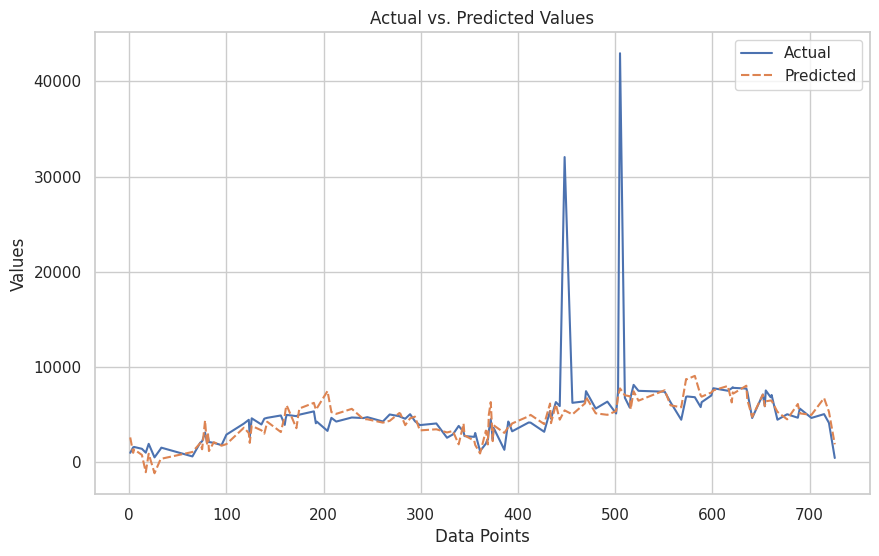

In [22]:
actual_vs_predicted(y_validate, y_pred)

Aus dem Diagramm wird ersichtlich, dass unser ```baseline_model``` aufgrund der Ausreißer im Label ```cnt``` noch Schwierigkeiten bei der Vorhersage hat.

## 4 Missing Value Handling

<Axes: >

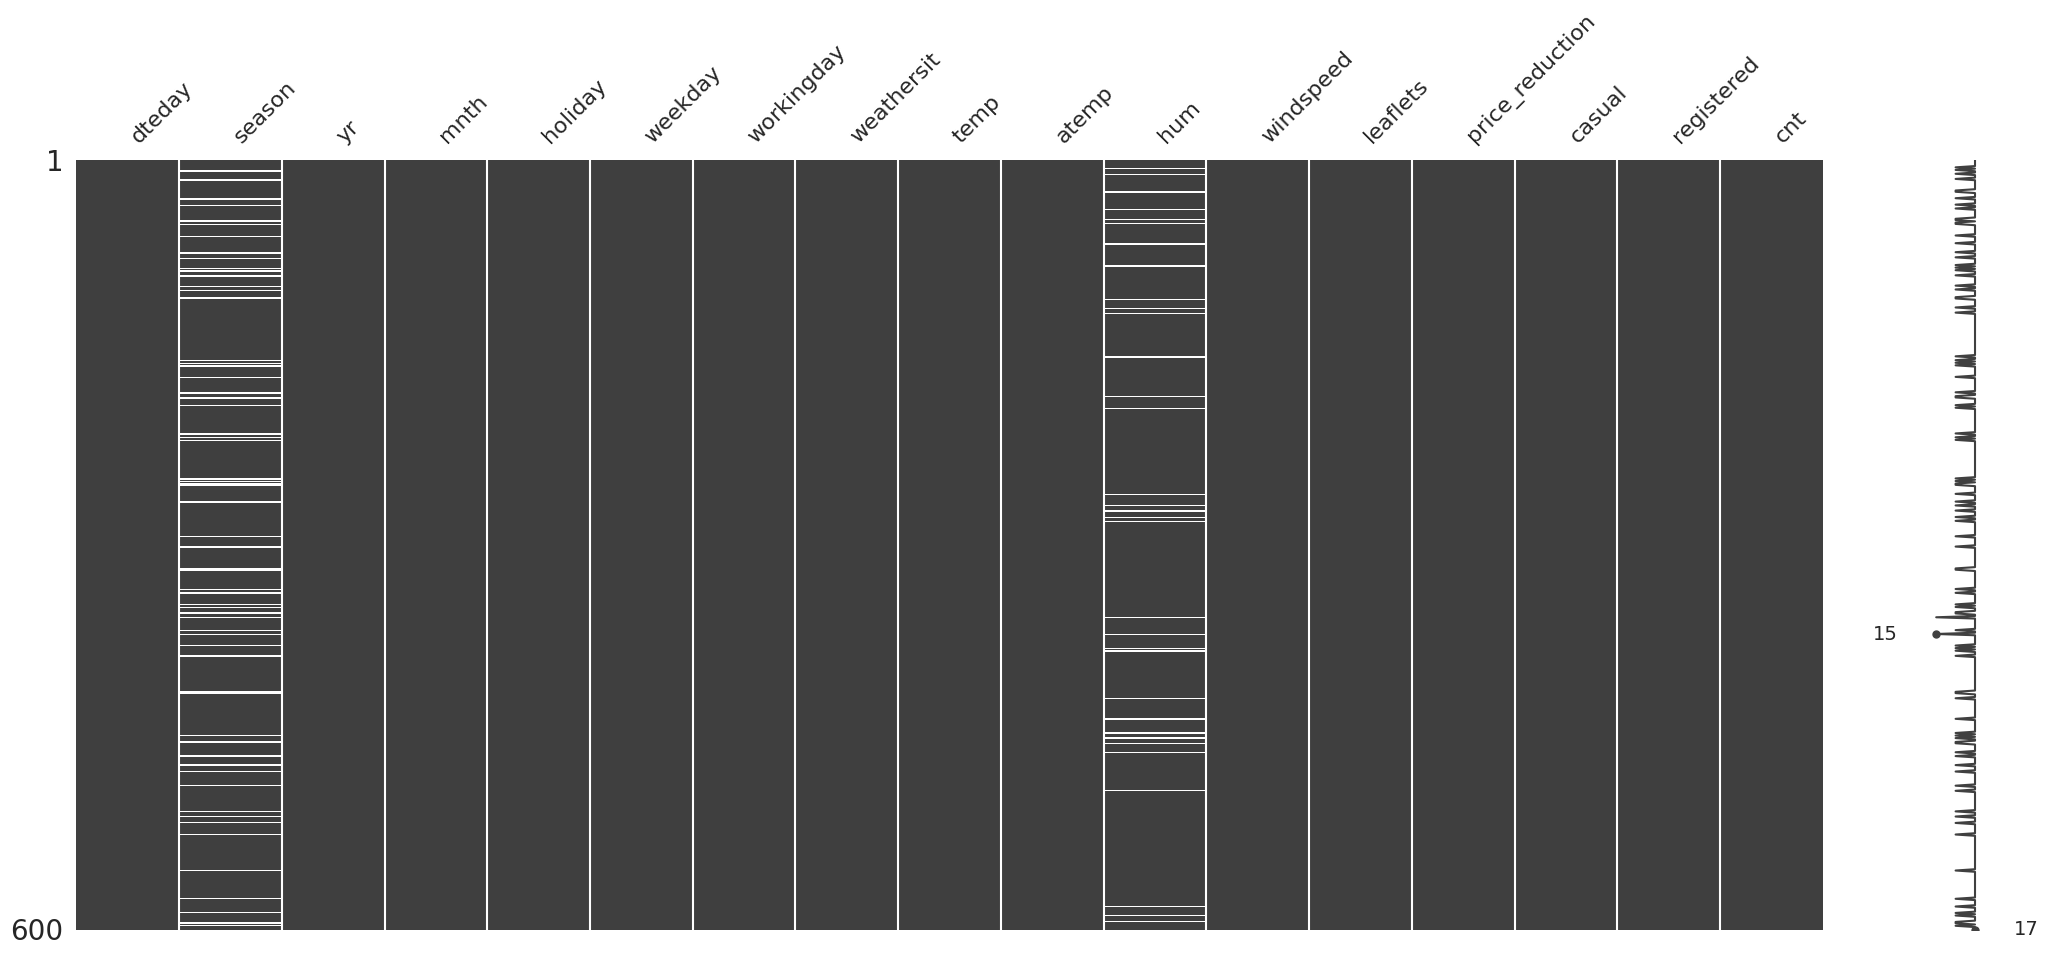

In [23]:
msno.matrix(train_data)

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. 

Im `minimal_preprocessing` werden alle `NaN` Werte mit durch den `SimpleImputer` mit `mean` aufgefüllt.

Nun sollen die fehlenden Werte in der Spalte `season` anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt werden. 

`impute_season` bestimmt die Jahreszeit anhand eines Datums im Format `"%d.%m.%y"`. 

Diese liest den Tag des entsprechenden Datums aus und weist diesen der dafür entsprechenden Season zu.

Es gibt vier fest definierte Zeitpunkte für den Beginn jeder Jahreszeit (Frühling, Sommer, Herbst, Winter).

Diese Zeitpunkte sind auf den 20. März, 20. Juni, 20. September und 20. Dezember festgelegt.

Damit wir die entsprechende Season anhand des Datums bestimmen können, müssen wir die Werte der Spalte `dteday` zuvor in `datetime` Objekte umwandeln. 

Dafür nutzen wir die `feature_to_datetime` Funktion, welche der preprocessing Pipeline als CustomTransformer mitgegeben wird.

In [24]:
def feature_to_datetime(df: pd.DataFrame, target: str, date_format: str = "%d.%m.%Y") -> pd.DataFrame:
    """
    Convert the feature to datetime.
    
    Args:
        df: pd.DataFrame: The DataFrame to be transformed.
        target: str: The feature to be transformed.
        date_format: str: The format of the date.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    df[target] = pd.to_datetime(df[target], format=date_format)
    
    return df

In [25]:
def impute_season(df: pd.DataFrame, target: str, date: str) -> pd.DataFrame:
    """
    Impute season based on target column value.
    
    Args:
        df (pd.DataFrame): DataFrame
        target (str): target column name
    
    Returns:
        pd.DataFrame: DataFrame with season imputed based on target column value
    """
    def get_season(date):
        day_of_year = date.timetuple().tm_yday
        if 80 <= day_of_year < 172:
            return 2
        elif 172 <= day_of_year < 265:
            return 3
        elif 265 <= day_of_year < 355:
            return 4
        else:
            return 1
        
    if date in df.columns:
        df[target] = df[date].apply(get_season)
        
    return df

In der folgenden Zelle definieren wir die einzelnen `CustomTransformer` um die beschriebene Funktionaliät umzusetzten.

In [26]:
feature_datetime = CustomTransformer(function=feature_to_datetime, config={"target": "dteday"})

season_imputer = CustomTransformer(function=impute_season, config={"target": "season", "date": "dteday"})

missing_value_pipeline = Pipeline([
    ("feature_datetime", feature_datetime),
    ("season_imputer", season_imputer)])

Hier wird die eben definierte Pipeline mit der minimal Pipeline dem ersten Schritt kombiniert.

In [27]:
pipeline = Pipeline([
    ("missing_value_pipeline", missing_value_pipeline),
    ("minimal_pipeline", minimal_pipeline)])

Danach holen wir uns den transfromierten Datensatz aus der Pipeline.

In [28]:
processed_data = pipeline.fit_transform(train_data[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)


In [29]:
processed_data_features = pipeline.named_steps['minimal_pipeline'].named_steps['imputer'].get_feature_names_out()

Wir entfernen das dteday Feature aus der temp_features liste, weil es durch den numeric_values Transformer aus den transformierten Daten entfernt wurde und wandeln das result in einen Dataframe um.

In [30]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data.index)

In [31]:
processed_data.head().T

instant,154,685,368,472,442
season,2.000000,4.000000,1.000000,2.000000,1.000000
yr,0.000000,1.000000,1.000000,1.000000,1.000000
mnth,6.000000,11.000000,1.000000,4.000000,3.000000
holiday,0.000000,0.000000,0.000000,1.000000,0.000000
weekday,5.000000,4.000000,2.000000,1.000000,-1.000000
workingday,1.000000,1.000000,1.000000,0.000000,0.000000
weathersit,1.000000,2.000000,1.000000,1.000000,2.000000
temp,24.800000,12.866700,6.000000,26.566700,20.566700
atemp,0.587133,0.324492,0.126275,0.614925,0.505046
hum,53.125050,93.062550,66.187500,84.250050,113.374950


In [32]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,600.0,2.461667,1.110820,1.00000,1.000000,2.000000,3.000000,4.000000
yr,600.0,0.496667,0.500406,0.00000,0.000000,0.000000,1.000000,1.000000
mnth,600.0,6.475000,3.442741,1.00000,4.000000,6.000000,9.000000,12.000000
holiday,600.0,0.030000,0.170730,0.00000,0.000000,0.000000,0.000000,1.000000
weekday,600.0,2.928333,2.079360,-1.00000,1.000000,3.000000,5.000000,6.000000
workingday,600.0,0.680000,0.466865,0.00000,0.000000,1.000000,1.000000,1.000000
weathersit,600.0,1.401667,0.542360,1.00000,1.000000,1.000000,2.000000,3.000000
temp,600.0,19.808284,7.206843,2.36520,13.575000,20.100000,26.058300,34.466700
atemp,600.0,0.473620,0.160439,0.07907,0.338256,0.489690,0.605127,0.826371
hum,600.0,93.845200,20.764975,28.18755,78.359363,93.845200,108.437550,145.875000


In [33]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data["cnt"], test_size=0.2, random_state=42)

In [34]:
baseline_model_02 = Pipeline([("baseline_model", LinearRegression())])

In [35]:
baseline_model_02.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [36]:
y_pred = baseline_model_02.predict(X_validate)

In [37]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.22
Adjusted R2: 0.13
MAE: 1316.62
RMSE: 4149.17


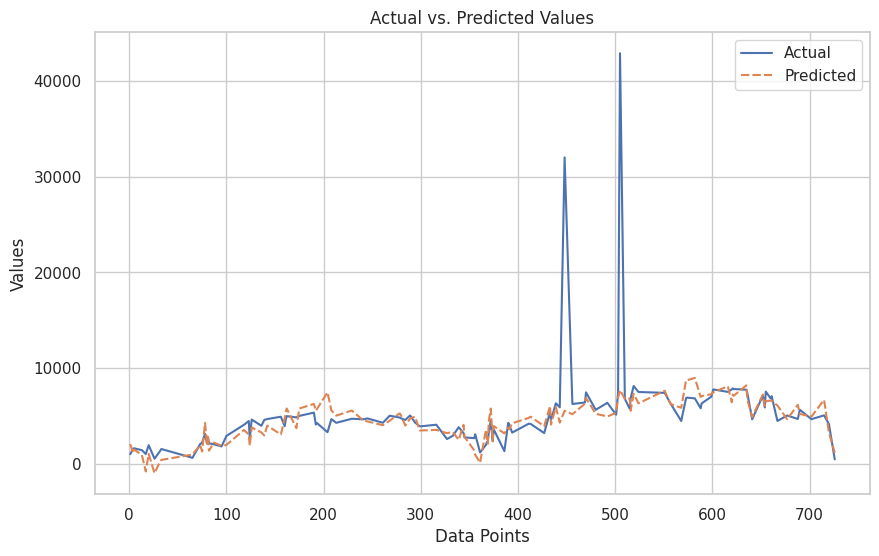

In [38]:
actual_vs_predicted(y_validate, y_pred)

Anhand der Performace Measures ist zu erkennen, dass sich durch diesen Schritt keine wesentlichen Verbesserungen ergeben haben.

## 5 Data Corrections

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable `windspeed` bei `-1` liegt. 

Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss.

Die folgenden Funktionen können die fehlerhaften Werte entweder entfernen oder duch den Mittelwert ersetzen.

In [39]:
def remove_below_thresh(df: pd.DataFrame, target: str, threshold: Union[int, float]) -> pd.DataFrame:
    """
    Remove rows where target is below threshold.
    
    Args:
        df (pd.DataFrame): DataFrame
        target (str): target column name
        thresh (int or float): threshold value
    
    Returns:
        pd.DataFrame: DataFrame with rows removed where target is below threshold
    """
    if target in df.columns:
        try:
            df = df[df[target] >= threshold]
            print(f"Rows with {target} below {threshold} removed")
        except KeyError:
            print(f"Column {target} not found in DataFrame")
    
    return df


In [40]:
def impute_below_thresh(df: pd.DataFrame, target: str, threshold: Union[int, float] = 3.0) -> pd.DataFrame:
    """
    Impute values in the target column below the threshold with the mean.
    
    Args:
        df (pd.DataFrame): The DataFrame to be transformed.
        target (str): The target column for imputation.
        threshold (Union[int, float]): The threshold below which values will be imputed with the mean.

    Returns:
        pd.DataFrame: The transformed DataFrame with values in the target column below the threshold imputed with the mean.
    """
    if target in df.columns:
        try:
            mean_value = df[df[target] >= threshold][target].mean()
            
            df.loc[df[target] < threshold, target] = mean_value
            
            print(f"Values in '{target}' below {threshold} imputed with mean: {mean_value:.2f}")
        except Exception as e:
            print(f"Error during imputation: {e}")
    else:
        print(f"{target} not found in DataFrame")
        
    return df

In [41]:
def process_weekday(df: pd.DataFrame, target: str, date: str) -> pd.DataFrame:
    """
    Maps weekday based on date column values.
    
    Args:
        df (pd.DataFrame): DataFrame
        date (str): date column name (in datetime64 format)
    
    Returns:
        pd.DataFrame: DataFrame with 'weekday' column mapped based on date column values.
    """
    if date in df.columns:
        df[target] = (df[date].dt.dayofweek + 1) % 7
    return df

Wie im letzten Schritt definieren wir den `CustomTransformer`, um die Werte von `weekday` zu korrigieren.

In [42]:
#windspeed_transformer = CustomTransformer(function=impute_below_thresh, config={"target": "windspeed", "threshold": 0.0})
windspeed_transformer = CustomTransformer(function=remove_below_thresh, config={"target": "windspeed", "threshold": 0.0})

windspeed_transformer_pipeline = Pipeline([
    ("windspeed_transformer", windspeed_transformer)])

In [43]:
train_data_windspeed_transformed = windspeed_transformer_pipeline.fit_transform(train_data)

Rows with windspeed below 0.0 removed


In [44]:
weekday_by_date = CustomTransformer(function=process_weekday, config={"target": "weekday", "date": "dteday"})

data_correction_pipeline = Pipeline([
    ("weekday_by_date", weekday_by_date)])

In [45]:
pipeline = Pipeline([
    ("missing_value_pipeline", missing_value_pipeline),
    ("data_correction_pipeline", data_correction_pipeline),
    ("minimal_pipeline", minimal_pipeline)])

In [46]:
processed_data = pipeline.fit_transform(train_data_windspeed_transformed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [47]:
processed_data_features = pipeline.named_steps['minimal_pipeline'].named_steps['imputer'].get_feature_names_out()

In [48]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data_windspeed_transformed.index)

In [49]:
processed_data.head().T

instant,154,685,368,472,442
season,2.000000,4.000000,1.000000,2.000000,1.000000
yr,0.000000,1.000000,1.000000,1.000000,1.000000
mnth,6.000000,11.000000,1.000000,4.000000,3.000000
holiday,0.000000,0.000000,0.000000,1.000000,0.000000
weekday,5.000000,4.000000,2.000000,1.000000,6.000000
workingday,1.000000,1.000000,1.000000,0.000000,0.000000
weathersit,1.000000,2.000000,1.000000,1.000000,2.000000
temp,24.800000,12.866700,6.000000,26.566700,20.566700
atemp,0.587133,0.324492,0.126275,0.614925,0.505046
hum,53.125050,93.062550,66.187500,84.250050,113.374950


In [50]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,596.0,2.459732,1.113729,1.000000,1.000000,2.000000,3.000000,4.000000
yr,596.0,0.500000,0.500420,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,596.0,6.469799,3.453036,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,596.0,0.030201,0.171285,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,596.0,3.018456,2.002854,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,596.0,0.681208,0.466400,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,596.0,1.404362,0.543176,1.000000,1.000000,1.000000,2.000000,3.000000
temp,596.0,19.759794,7.206026,2.365200,13.491675,19.966650,26.000000,34.466700
atemp,596.0,0.472574,0.160457,0.079070,0.337891,0.487364,0.603868,0.826371
hum,596.0,93.962982,20.766043,28.187550,78.468712,93.962982,108.437550,145.875000


In [51]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data_windspeed_transformed["cnt"], test_size=0.2, random_state=42)

In [52]:
baseline_model_03 = Pipeline([("baseline_model", LinearRegression())])

In [53]:
baseline_model_03.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [54]:
y_pred = baseline_model_03.predict(X_validate)

In [55]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.29
Adjusted R2: 0.20
MAE: 991.92
RMSE: 3333.69


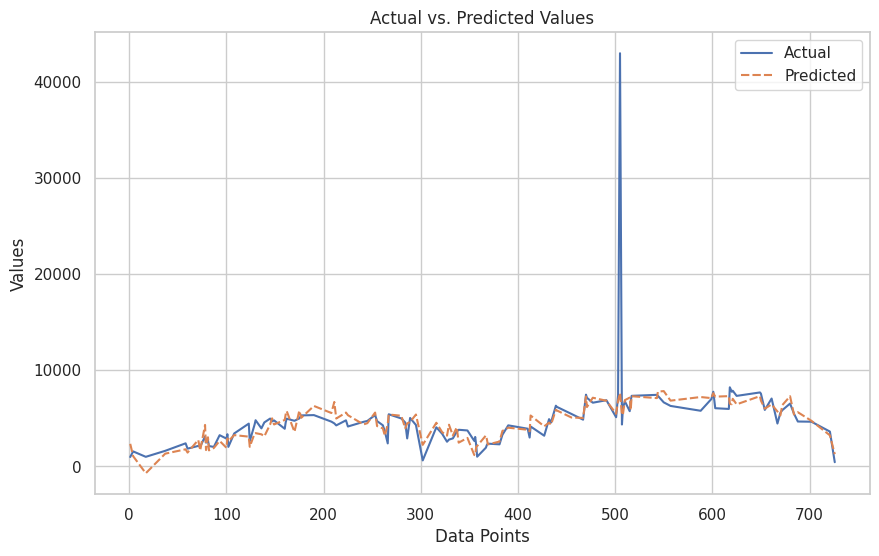

In [56]:
actual_vs_predicted(y_validate, y_pred)

Nachdem die Daten korregiert wurden, ist zu erkennen, dass einige Ausreißer mit den falschen Werten von `windspeed` entfernt wurden.

Zudem ist eine leichte Verbesserung in den Preformance Measures zu erkennen.

## 6 Outlier Handling

Es ist zu sehen, dass die Gesamtanzahl der geliehenen Fahrräder und die Anzahl der durch `casual` Nutzer geliehenen Fahrräder unrealistisch hohe Maximalwerte aufweisen.

In [57]:
train_data[['casual', 'cnt']].describe().T

,count,mean,std,min,25%,50%,75%,max
casual,600.0,1070.895000,2971.316154,2.0,313.0,722.0,1078.0,47138.0
cnt,600.0,4705.011667,3588.750428,22.0,3135.0,4530.0,5909.5,53021.0


In [58]:
zscores = stats.zscore(train_data["casual"])
thresh = 3.0
outliers = train_data[abs(zscores) > thresh]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price_reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
631,22.09.2012,3.0,1,9,0,6,0,1,26.0000,0.610488,97.00005,0.283583,963,0,47138,5883,53021
505,19.05.2012,2.0,1,5,0,6,0,1,24.0000,0.566908,68.43750,0.083975,1030,0,38061,4884,42945
448,23.03.2012,2.0,1,3,0,5,1,2,24.0667,0.570067,104.12505,0.116300,535,1,26150,5893,32043
624,15.09.2012,3.0,1,9,0,6,0,1,24.3333,0.585867,75.25005,0.247521,820,0,30378,5554,35932


Da `cnt` die Summe aus `casual` und `registered` ist, werden beim Entfernen der Outlier von `casual` auch die Outlier von `cnt` entfernt.

In [59]:
def remove_outliers(df: pd.DataFrame, target: str, threshold: float = 3.0) -> pd.DataFrame:
    """
    Drop outliers from target column based on Z-scores.
    
    Args:
        df (pd.DataFrame): DataFrame to process.
        target (str): Target column name for outlier removal.
        threshold (float): Z-score threshold to consider a data point an outlier.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed from the specified target column.
    """
    if target in df.columns:
        # Calculate Z-scores for the target column
        z_scores = stats.zscore(df[target].dropna())
        
        # Identify outliers
        outliers = df[abs(z_scores) > threshold]
        
        df = df.drop(outliers.index, errors="ignore")

        print(f"{df.shape[0]} rows remaining after removing outliers.")
    return df

Hier kann Regression Imputation besser sein, da es sich bei den Outliern um das Label handelt?

In [60]:
def impute_outliers_with_mean(df: pd.DataFrame, targets: list[str], threshold: float = 3.0) -> pd.DataFrame:
    """
    Impute values in the target columns that are outliers based on Z-scores with the mean of the columns.
    
    Args:
        df (pd.DataFrame): The DataFrame to be transformed.
        targets (list[str]): The list of target columns for imputation.
        threshold (float): The Z-score threshold to identify outliers.

    Returns:
        pd.DataFrame: The transformed DataFrame with outliers in the target columns imputed with the mean.
    """
    for target in targets:
        if target in df.columns:
            try:
                # Calculate the mean of the target column excluding NaN values
                mean_value = df[target].mean()
                
                # Calculate Z-scores for the target column
                z_scores = stats.zscore(df[target].fillna(mean_value))
                
                # Identify indices where the absolute Z-scores are greater than the threshold
                outlier_indices = np.where(np.abs(z_scores) > threshold)
                
                # Impute these values with the column's mean
                df.loc[df.index[outlier_indices], target] = int(mean_value)
                
                print(f"Outliers in '{target}' imputed with mean: {int(mean_value)}")
            except Exception as e:
                print(f"Error in impute_outliers_with_mean for column '{target}': {e}")
        else:
            print(f"Column '{target}' not found in DataFrame.")
        
    return df

In [61]:
remove_outliers = CustomTransformer(function=remove_outliers, config={"target": "casual"})
#remove_outliers = CustomTransformer(function=impute_outliers_with_mean, config={"targets": ["cnt", "casual"]})

remove_outliers_pipeline = Pipeline([
    ("remove_outliers", remove_outliers)])

In [62]:
train_data_outliers_removed = remove_outliers_pipeline.fit_transform(train_data_windspeed_transformed)

592 rows remaining after removing outliers.


In [63]:
train_data_outliers_removed.head().T

instant,154,685,368,472,442
dteday,03.06.2011,15.11.2012,03.01.2012,16.04.2012,17.03.2012
season,2.0,4.0,1.0,2.0,1.0
yr,0,1,1,1,1
mnth,6,11,1,4,3
holiday,0,0,0,1,0
weekday,5,4,2,1,-1
workingday,1,1,1,0,0
weathersit,1,2,1,1,2
temp,24.8,12.8667,6.0,26.5667,20.5667
atemp,0.587133,0.324492,0.126275,0.614925,0.505046


In [64]:
train_data_outliers_removed.describe().T

,count,mean,std,min,25%,50%,75%,max
season,531.0,2.435028,1.112967,1.000000,1.000000,2.000000,3.000000,4.000000
yr,592.0,0.496622,0.500411,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,592.0,6.469595,3.458101,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,592.0,0.030405,0.171845,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,592.0,2.895270,2.070462,-1.000000,1.000000,3.000000,5.000000,6.000000
workingday,592.0,0.684122,0.465258,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,592.0,1.405405,0.543696,1.000000,1.000000,1.000000,2.000000,3.000000
temp,592.0,19.727090,7.219009,2.365200,13.458350,19.866650,26.008325,34.466700
atemp,592.0,0.471826,0.160733,0.079070,0.337628,0.483262,0.603868,0.826371
hum,558.0,94.018608,21.415990,28.187550,77.559825,93.468750,110.171850,145.875000


In [65]:
pipeline = Pipeline([
    ("missing_value_pipeline", missing_value_pipeline),
    ("data_correction_pipeline", data_correction_pipeline),
    ("minimal_pipeline", minimal_pipeline)])

In [66]:
processed_data = pipeline.fit_transform(train_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [67]:
processed_data_features = pipeline.named_steps['minimal_pipeline'].named_steps['imputer'].get_feature_names_out()

In [68]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data_outliers_removed.index)

In [69]:
processed_data.head().T

instant,154,685,368,472,442
season,2.000000,4.000000,1.000000,2.000000,1.000000
yr,0.000000,1.000000,1.000000,1.000000,1.000000
mnth,6.000000,11.000000,1.000000,4.000000,3.000000
holiday,0.000000,0.000000,0.000000,1.000000,0.000000
weekday,5.000000,4.000000,2.000000,1.000000,6.000000
workingday,1.000000,1.000000,1.000000,0.000000,0.000000
weathersit,1.000000,2.000000,1.000000,1.000000,2.000000
temp,24.800000,12.866700,6.000000,26.566700,20.566700
atemp,0.587133,0.324492,0.126275,0.614925,0.505046
hum,53.125050,93.062550,66.187500,84.250050,113.374950


In [70]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,592.0,2.457770,1.115150,1.000000,1.000000,2.000000,3.000000,4.000000
yr,592.0,0.496622,0.500411,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,592.0,6.469595,3.458101,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,592.0,0.030405,0.171845,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,592.0,3.000000,1.996613,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,592.0,0.684122,0.465258,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,592.0,1.405405,0.543696,1.000000,1.000000,1.000000,2.000000,3.000000
temp,592.0,19.727090,7.219009,2.365200,13.458350,19.866650,26.008325,34.466700
atemp,592.0,0.471826,0.160733,0.079070,0.337628,0.483262,0.603868,0.826371
hum,592.0,94.018608,20.790838,28.187550,78.593775,94.018608,108.609413,145.875000


In [71]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data_outliers_removed["cnt"], test_size=0.2, random_state=42)

In [72]:
baseline_model_04 = Pipeline([("baseline_model", LinearRegression())])

In [73]:
baseline_model_04.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [74]:
y_pred = baseline_model_04.predict(X_validate)

In [75]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.85
Adjusted R2: 0.83
MAE: 637.68
RMSE: 759.06


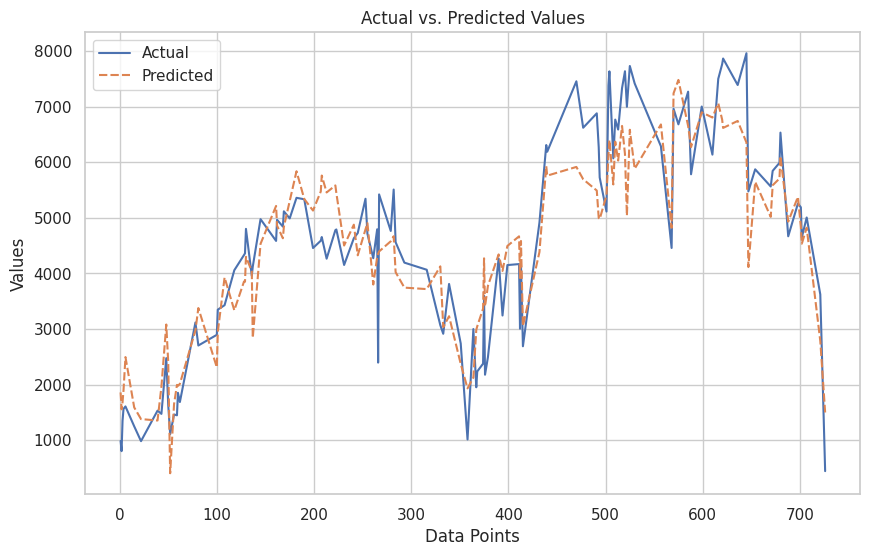

In [76]:
actual_vs_predicted(y_validate, y_pred)

Es ist zu erkennen, dass die Performace Measures, nach der Entfernung der Outliers, eine wesentliche Verbesserung zeigen.

## 7 Feature Transformation

### 7.1 One Hot Encoding

Für die Variablen `weekday`, `season` und `weathersit` erstellen wir mittels One Hot Encoding separate binäre Spalten für jede Ausprägung. 

Anschließend entfernen wir die ursprünglichen drei Spalten.

In [77]:
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse_output=False, drop="first", dtype=int), ['weekday', 'season', 'weathersit'])],
    remainder='passthrough'
)

In [78]:
pipeline_01 = Pipeline([
    ("missing_value_pipeline", missing_value_pipeline),
    ("data_correction_pipeline", data_correction_pipeline),
    ("drop_feature_01", drop_feature_01),
    ("numeric_values", numeric_values)])

In [79]:
pipeline_02 = Pipeline([
    ("column_transformer", column_transformer),
    ("imputer", SimpleImputer(strategy="mean"))])

In [80]:
pipeline = Pipeline([
    ("pipeline_01", pipeline_01),
    ("pipeline_02", pipeline_02)])

In [81]:
processed_data = pipeline.fit_transform(train_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [82]:
processed_data_features = pipeline.named_steps["pipeline_02"].named_steps['column_transformer'].get_feature_names_out()

In [83]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data_outliers_removed.index)

In [84]:
processed_data.head().T

instant,154,685,368,472,442
one_hot_encoder__weekday_1,0.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__weekday_2,0.000000,0.000000,1.000000,0.000000,0.000000
one_hot_encoder__weekday_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_5,1.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_6,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,1.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__season_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weathersit_2,0.000000,1.000000,0.000000,0.000000,1.000000


In [85]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
one_hot_encoder__weekday_1,592.0,0.143581,0.350961,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_2,592.0,0.140203,0.347491,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_3,592.0,0.145270,0.352671,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_4,592.0,0.148649,0.356043,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_5,592.0,0.136824,0.343952,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_6,592.0,0.143581,0.350961,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,592.0,0.258446,0.438151,0.000000,0.000000,0.000000,1.000000,1.000000
one_hot_encoder__season_3,592.0,0.244932,0.430411,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_4,592.0,0.236486,0.425284,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weathersit_2,592.0,0.351351,0.477796,0.000000,0.000000,0.000000,1.000000,1.000000


In [86]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data_outliers_removed["cnt"], test_size=0.2, random_state=42)

In [87]:
baseline_model_05 = Pipeline([("baseline_model", LinearRegression())])

In [88]:
baseline_model_05.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [89]:
y_pred = baseline_model_05.predict(X_validate)

In [90]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.89
Adjusted R2: 0.86
MAE: 516.80
RMSE: 654.90


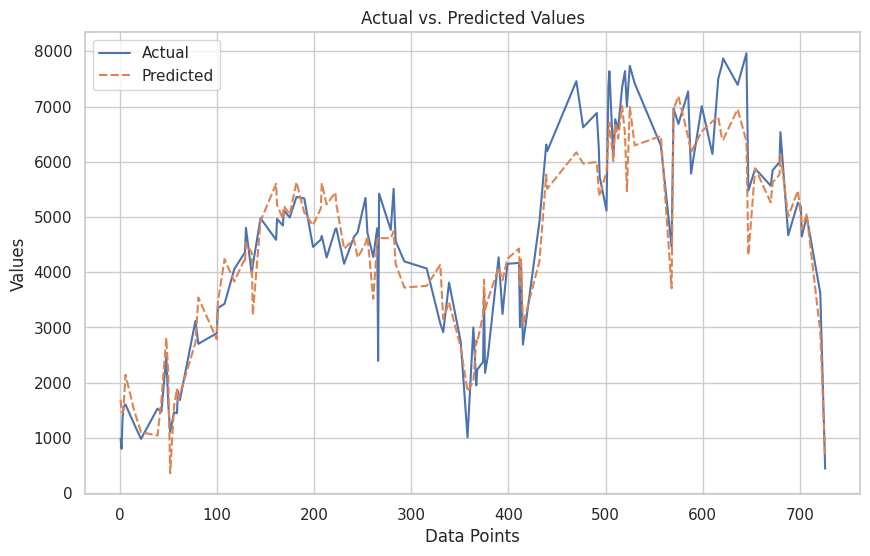

In [91]:
actual_vs_predicted(y_validate, y_pred)

Nach dem Anwenden von One Hot Encoding zeigt sich erneut eine leicht Verbesserung der Performance Measures.

### 7.2 Normalisierung 

Im Folgenden werden alle Features mit Hilfe eines ```StandardScalers``` normalisiert, um den Einfluss der Gewichtung einzelner Features, aufgrund ihrer Wertebereiche, zu eliminiern.

Es ist zu erwarten, dass der Mean Absolute Error durch die Normalisierung geringer wird.

In [92]:
column_transformer_02 = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse_output=False, drop="first", dtype=int), ['weekday', 'season', 'weathersit'])],
    remainder=StandardScaler()
)

In [93]:
pipeline_02 = Pipeline([
    ("column_transformer_02", column_transformer_02),
    ("imputer", SimpleImputer(strategy="mean"))])

In [94]:
pipeline = Pipeline([
    ("pipeline_01", pipeline_01),
    ("pipeline_02", pipeline_02)])

In [95]:
processed_data = pipeline.fit_transform(train_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [96]:
processed_data_features = pipeline.named_steps["pipeline_02"].named_steps['column_transformer_02'].get_feature_names_out()

In [97]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data_outliers_removed.index)

In [98]:
processed_data.head().T

instant,154,685,368,472,442
one_hot_encoder__weekday_1,0.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__weekday_2,0.000000,0.000000,1.000000,0.000000,0.000000
one_hot_encoder__weekday_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_5,1.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_6,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,1.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__season_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weathersit_2,0.000000,1.000000,0.000000,0.000000,1.000000


In [99]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
one_hot_encoder__weekday_1,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_2,592.0,1.402027e-01,0.347491,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_3,592.0,1.452703e-01,0.352671,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_4,592.0,1.486486e-01,0.356043,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_5,592.0,1.368243e-01,0.343952,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_6,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__season_2,592.0,2.584459e-01,0.438151,0.000000,0.000000,0.000000e+00,1.000000,1.000000
one_hot_encoder__season_3,592.0,2.449324e-01,0.430411,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__season_4,592.0,2.364865e-01,0.425284,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weathersit_2,592.0,3.513514e-01,0.477796,0.000000,0.000000,0.000000e+00,1.000000,1.000000


In [100]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data_outliers_removed["cnt"], test_size=0.2, random_state=42)

In [101]:
baseline_model_06 = Pipeline([("baseline_model", LinearRegression())])

In [102]:
baseline_model_06.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [103]:
y_pred = baseline_model_06.predict(X_validate)

In [104]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.89
Adjusted R2: 0.86
MAE: 516.80
RMSE: 654.90


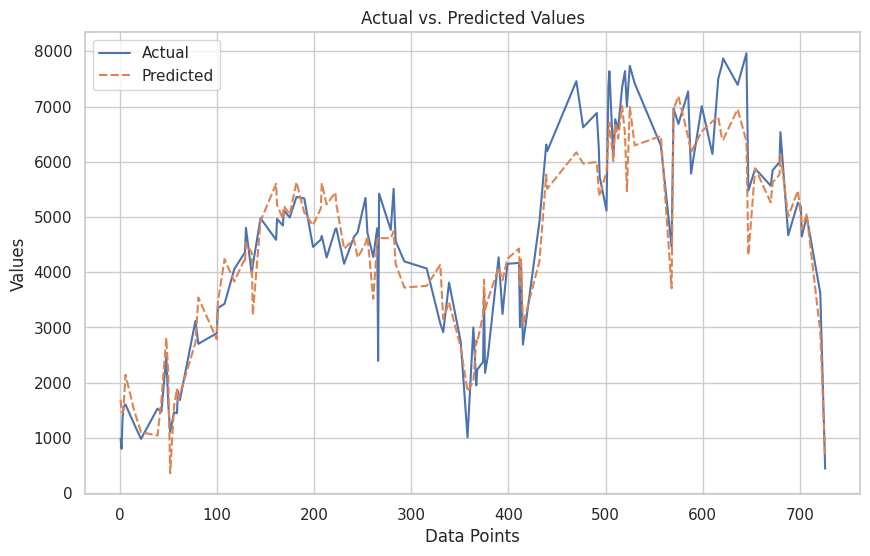

In [105]:
actual_vs_predicted(y_validate, y_pred)

Durch das Anwenden des `StandardScaler` zeigt sich eine leichte Verbesserung des Mean Absolute Errors.

## 8 Multicolinearity

In der Korrelationsmatrix ist zu sehen, dass die Variablen `atemp`, und `temp` eine starke Korrelation aufweisen. 

Dies kann später zu Problemen bei der Regression führen, daher werden wir nur `atemp` behalten.

Wir verwenden die gefühlte Temperatur, da diese zu einem Grad aus der tatasächlichen Temperatur und der Luftfeuchte hervorgeht.

In [106]:
drop_feature_02 = CustomTransformer(function=drop_features, config={"features": ["temp"]})

In [107]:
pipeline_01 = Pipeline([
    ("missing_value_pipeline", missing_value_pipeline),
    ("data_correction_pipeline", data_correction_pipeline),
    ("drop_feature_01", drop_feature_01),
    ("drop_feature_02", drop_feature_02),
    ("numeric_values", numeric_values)])

In [108]:
pipeline = Pipeline([
    ("pipeline_01", pipeline_01),
    ("pipeline_02", pipeline_02)])

In [109]:
processed_data = pipeline.fit_transform(train_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [110]:
processed_data_features = pipeline.named_steps["pipeline_02"].named_steps['column_transformer_02'].get_feature_names_out()

In [111]:
processed_data = pd.DataFrame(processed_data, columns=processed_data_features, index=train_data_outliers_removed.index)

In [112]:
processed_data.head().T

instant,154,685,368,472,442
one_hot_encoder__weekday_1,0.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__weekday_2,0.000000,0.000000,1.000000,0.000000,0.000000
one_hot_encoder__weekday_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_5,1.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_6,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,1.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__season_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weathersit_2,0.000000,1.000000,0.000000,0.000000,1.000000


In [113]:
processed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
one_hot_encoder__weekday_1,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_2,592.0,1.402027e-01,0.347491,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_3,592.0,1.452703e-01,0.352671,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_4,592.0,1.486486e-01,0.356043,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_5,592.0,1.368243e-01,0.343952,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weekday_6,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__season_2,592.0,2.584459e-01,0.438151,0.000000,0.000000,0.000000e+00,1.000000,1.000000
one_hot_encoder__season_3,592.0,2.449324e-01,0.430411,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__season_4,592.0,2.364865e-01,0.425284,0.000000,0.000000,0.000000e+00,0.000000,1.000000
one_hot_encoder__weathersit_2,592.0,3.513514e-01,0.477796,0.000000,0.000000,0.000000e+00,1.000000,1.000000


In [114]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_data, train_data_outliers_removed["cnt"], test_size=0.2, random_state=42)

In [115]:
baseline_model_07 = Pipeline([("baseline_model", LinearRegression())])

In [116]:
baseline_model_07.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [117]:
y_pred = baseline_model_07.predict(X_validate)

In [118]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.89
Adjusted R2: 0.87
MAE: 511.00
RMSE: 638.94


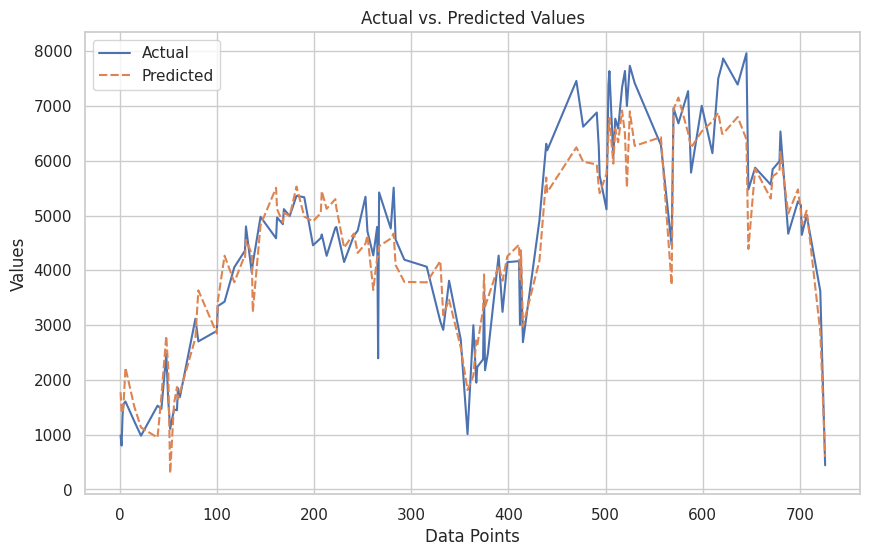

In [119]:
actual_vs_predicted(y_validate, y_pred)

Durch das Entfernen von `temp` sehen wir eine leichte Verschlechterung des Mean Absolute Errors.

## 9 Validierung des Modells

In [134]:
test_data_windspeed_transformed = windspeed_transformer_pipeline.fit_transform(test_data)

Rows with windspeed below 0.0 removed


In [135]:
test_data_outliers_removed = remove_outliers_pipeline.transform(test_data_windspeed_transformed)

131 rows remaining after removing outliers.


In [136]:
test_data_outliers_removed.head().T

instant,299,458,687,346,291
dteday,26.10.2011,02.04.2012,17.11.2012,12.12.2011,18.10.2011
season,4.0,2.0,4.0,4.0,4.0
yr,0,1,1,0,0
mnth,10,4,11,12,10
holiday,0,0,0,0,0
weekday,3,1,6,-1,2
workingday,1,1,0,1,1
weathersit,2,1,1,1,2
temp,19.3667,17.3565,13.0,9.5333,21.3
atemp,0.472846,0.427513,0.326383,0.270196,0.522721


In [137]:
test_data_outliers_removed.describe().T

,count,mean,std,min,25%,50%,75%,max
season,120.0,2.641667,1.121193,1.000000,2.000000,3.000000,4.000000,4.000000
yr,131.0,0.511450,0.501788,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,131.0,6.732824,3.505654,1.000000,3.500000,7.000000,10.000000,12.000000
holiday,131.0,0.022901,0.150161,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,131.0,2.564885,2.141528,-1.000000,1.000000,2.000000,4.500000,6.000000
workingday,131.0,0.709924,0.455539,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,131.0,1.374046,0.559339,1.000000,1.000000,1.000000,2.000000,3.000000
temp,131.0,19.830135,7.855589,3.895700,13.200000,19.033300,27.533350,33.933300
atemp,131.0,0.477278,0.174595,0.117930,0.325125,0.469054,0.636282,0.840896
hum,125.0,93.743081,21.525892,0.000000,80.673900,93.499950,107.500050,139.500000


In [138]:
processed_test_data = pipeline.transform(test_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [139]:
processed_test_data_features = pipeline.named_steps["pipeline_02"].named_steps['column_transformer_02'].get_feature_names_out()

In [140]:
processed_test_data = pd.DataFrame(processed_test_data, columns=processed_test_data_features, index=test_data_outliers_removed.index)

In [141]:
processed_test_data.head().T

instant,299,458,687,346,291
one_hot_encoder__weekday_1,0.000000,1.000000,0.000000,1.000000,0.000000
one_hot_encoder__weekday_2,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_3,1.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_4,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_5,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_6,0.000000,0.000000,1.000000,0.000000,0.000000
one_hot_encoder__season_2,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_4,1.000000,0.000000,1.000000,1.000000,1.000000
one_hot_encoder__weathersit_2,1.000000,0.000000,0.000000,0.000000,1.000000


In [142]:
processed_test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
one_hot_encoder__weekday_1,131.0,0.152672,0.361052,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_2,131.0,0.160305,0.368297,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_3,131.0,0.137405,0.345596,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_4,131.0,0.122137,0.328701,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_5,131.0,0.160305,0.368297,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_6,131.0,0.106870,0.310134,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,131.0,0.213740,0.411519,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_3,131.0,0.282443,0.451916,0.000000,0.000000,0.000000,1.000000,1.000000
one_hot_encoder__season_4,131.0,0.297710,0.459007,0.000000,0.000000,0.000000,1.000000,1.000000
one_hot_encoder__weathersit_2,131.0,0.297710,0.459007,0.000000,0.000000,0.000000,1.000000,1.000000


In [143]:
processed_train_data = pipeline.transform(test_data_outliers_removed[features])

/tmp/ipykernel_718776/208495991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = pd.to_datetime(df[target], format=date_format)
/tmp/ipykernel_718776/2224586021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[date].apply(get_season)
/tmp/ipykernel_718776/3999800440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [144]:
processed_train_data_features = pipeline.named_steps["pipeline_02"].named_steps['column_transformer_02'].get_feature_names_out()

In [145]:
processed_train_data = pd.DataFrame(processed_data, columns=processed_train_data_features, index=train_data_outliers_removed.index)

In [146]:
processed_train_data.head().T

instant,154,685,368,472,442
one_hot_encoder__weekday_1,0.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__weekday_2,0.000000,0.000000,1.000000,0.000000,0.000000
one_hot_encoder__weekday_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_5,1.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__weekday_6,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,1.000000,0.000000,0.000000,1.000000,0.000000
one_hot_encoder__season_3,0.000000,0.000000,0.000000,0.000000,0.000000
one_hot_encoder__season_4,0.000000,1.000000,0.000000,0.000000,0.000000
one_hot_encoder__weathersit_2,0.000000,1.000000,0.000000,0.000000,1.000000


In [147]:
processed_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
one_hot_encoder__weekday_1,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_2,592.0,1.402027e-01,0.347491,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_3,592.0,1.452703e-01,0.352671,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_4,592.0,1.486486e-01,0.356043,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_5,592.0,1.368243e-01,0.343952,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weekday_6,592.0,1.435811e-01,0.350961,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_2,592.0,2.584459e-01,0.438151,0.000000,0.000000,0.000000,1.000000,1.000000
one_hot_encoder__season_3,592.0,2.449324e-01,0.430411,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__season_4,592.0,2.364865e-01,0.425284,0.000000,0.000000,0.000000,0.000000,1.000000
one_hot_encoder__weathersit_2,592.0,3.513514e-01,0.477796,0.000000,0.000000,0.000000,1.000000,1.000000


In [148]:
X_train, X_validate, y_train, y_validate = train_test_split(processed_train_data, train_data_outliers_removed["cnt"], test_size=0.2, random_state=42)

In [149]:
evaluation = Pipeline([("baseline_model", LinearRegression())])

In [150]:
evaluation.fit(X_train, y_train)

Pipeline(steps=[('baseline_model', LinearRegression())])

In [151]:
y_pred = evaluation.predict(processed_test_data)

In [152]:
measures = performance_measures(test_data_outliers_removed["cnt"], y_pred, X_train.shape[1])

R2: 0.80
Adjusted R2: 0.77
MAE: 645.01
RMSE: 868.79


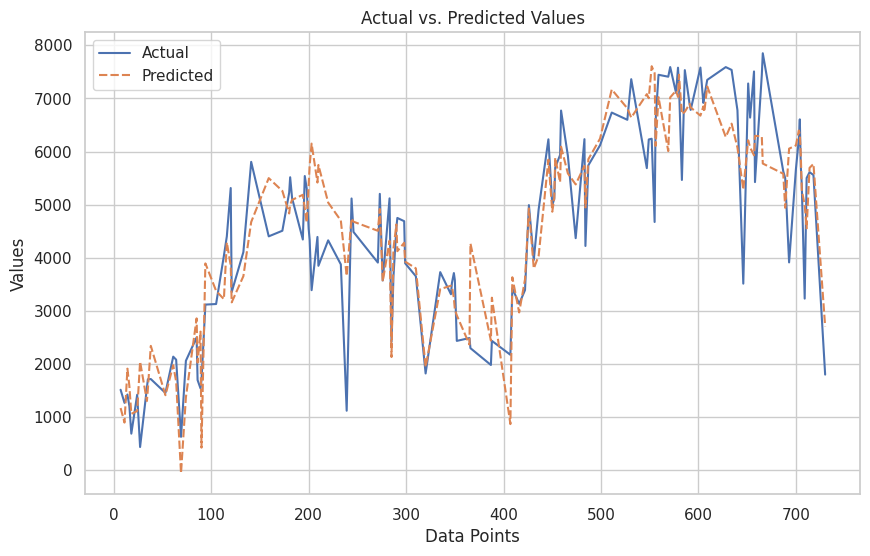

In [153]:
actual_vs_predicted(test_data_outliers_removed["cnt"], y_pred)

Zuletzt exportieren wir das Datenset als CSV und speichern das Model.

In [154]:
model_filename = '../models/final_model_task2.pkl'
pickle.dump(baseline_model_08, open(model_filename, 'wb'))

X_train_filename = '../data/X_train_task2.pkl'
pickle.dump(X_train, open(X_train_filename, 'wb'))
X_validate_filename = '../data/X_validate_task2.pkl'
pickle.dump(X_validate, open(X_validate_filename, 'wb'))
y_train_filename = '../data/y_train_task2.pkl'
pickle.dump(y_train, open(y_train_filename, 'wb'))
y_validate_filename = '../data/y_validate_task2.pkl'
pickle.dump(y_validate, open(y_validate_filename, 'wb'))

X_test_filename = '../data/X_test_task2.pkl'
pickle.dump(processed_test_data, open(X_test_filename, 'wb'))
y_test_filename = '../data/y_test_task2.pkl'
pickle.dump(test_data_outliers_removed["cnt"], open(y_test_filename, 'wb'))

print("All files saved successfully!")

All files saved successfully!


## Validierung des zuvor exportierten Modells.

In [155]:
loaded_model = pickle.load(open(model_filename, 'rb'))

In [156]:
X_test = pickle.load(open(X_test_filename, 'rb'))
y_test = pickle.load(open(y_test_filename, 'rb'))

In [157]:
y_pred = loaded_model.predict(X_test)

In [158]:
measures = performance_measures(y_test, y_pred, X_test.shape[1])

R2: 0.80
Adjusted R2: 0.77
MAE: 645.01
RMSE: 868.79


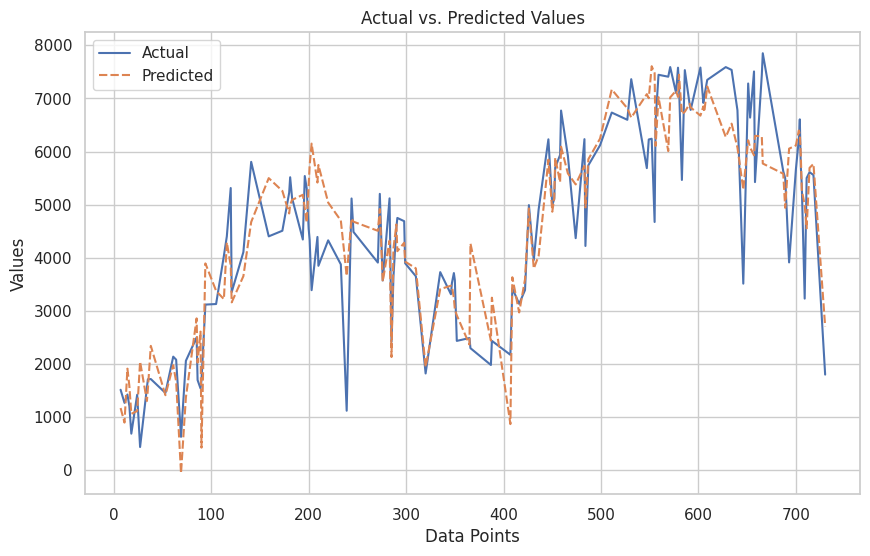

In [159]:
actual_vs_predicted(y_test, y_pred)

## Erneutes trainieren und validieren auf Basis der exportierten Daten

In [160]:
m = LinearRegression()

In [161]:
X_train = pickle.load(open(X_train_filename, 'rb'))
y_train = pickle.load(open(y_train_filename, 'rb'))

In [162]:
X_validate = pickle.load(open(X_validate_filename, 'rb'))
y_validate = pickle.load(open(y_validate_filename, 'rb'))

In [163]:
m.fit(X_train, y_train)

LinearRegression()

In [164]:
y_pred = m.predict(X_validate)

In [165]:
measures = performance_measures(y_validate, y_pred, X_train.shape[1])

R2: 0.89
Adjusted R2: 0.87
MAE: 506.23
RMSE: 647.01


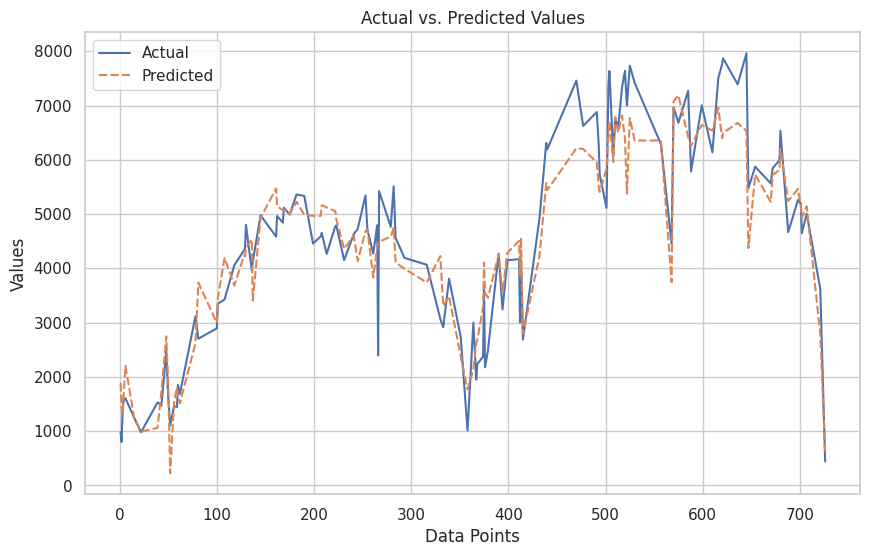

In [166]:
actual_vs_predicted(y_validate, y_pred)